In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


/var/folders/qt/4m623cks1dggfkj22ryqr2zc0000gq/T/ipykernel_56960/370812658.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Load the dataset
df = pd.read_csv('../../scripts/intent_dataset.csv')

# Inspect the data
print(df.head())
print(df['intent'].value_counts())
print(df.info())


                                               query  intent
0  ¡Claro! Aquí tienes algunas preguntas relacion...  grades
1     ¿Qué puntaje necesito para aprobar la materia?  grades
2  ¿Cómo puedo interpretar mis resultados en el e...  grades
3  ¿Qué estrategias puedo utilizar para estudiar ...  grades
4  ¿Qué recursos adicionales puedo utilizar para ...  grades
intent
grades        1000
attendance    1000
schedule      1000
general       1000
links          955
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4955 entries, 0 to 4954
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   query   4955 non-null   object
 1   intent  4955 non-null   object
dtypes: object(2)
memory usage: 77.6+ KB
None


In [5]:
# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-záéíóúñü¿?¡!0-9\s]', '', text)
    return text

# Apply cleaning
df['query'] = df['query'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['query'], df['intent_encoded'], test_size=0.2, random_state=42, stratify=df['intent_encoded']
)


In [6]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [7]:
# Train the classifier
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_tfidf, y_train)

# Evaluate on the test set
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

  attendance       0.99      0.99      0.99       200
     general       0.95      0.96      0.96       200
      grades       0.97      0.99      0.98       200
       links       0.98      0.97      0.98       191
    schedule       1.00      0.97      0.99       200

    accuracy                           0.98       991
   macro avg       0.98      0.98      0.98       991
weighted avg       0.98      0.98      0.98       991



In [14]:
# Save artifacts
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(clf, 'intent_classifier.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [15]:
# Load artifacts
vectorizer = joblib.load('vectorizer.pkl')
clf = joblib.load('intent_classifier.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Predict on a new query
new_query = "¿A qué hora es mi clase?"
clean_query = clean_text(new_query)
query_vectorized = vectorizer.transform([clean_query])
predicted_intent = label_encoder.inverse_transform(clf.predict(query_vectorized))
print(f"Predicted intent: {predicted_intent[0]}")


Predicted intent: schedule


In [12]:
from sklearn.model_selection import GridSearchCV

# Grid search for hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate best model
y_pred = best_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Best parameters: {'C': 10, 'solver': 'liblinear'}
              precision    recall  f1-score   support

  attendance       0.99      0.99      0.99       200
     general       0.96      0.96      0.96       200
      grades       0.96      0.99      0.98       200
       links       0.99      0.98      0.99       191
    schedule       0.99      0.97      0.98       200

    accuracy                           0.98       991
   macro avg       0.98      0.98      0.98       991
weighted avg       0.98      0.98      0.98       991



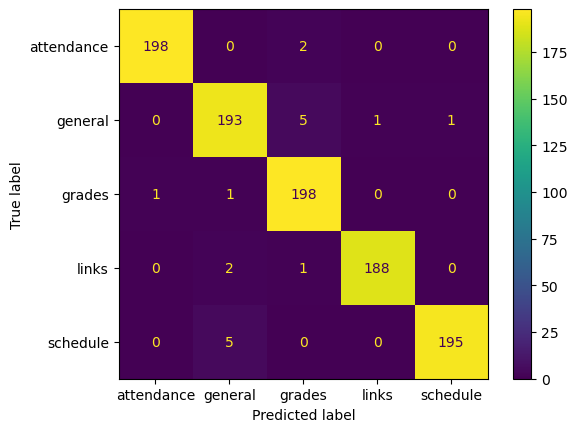

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test_tfidf, y_test, display_labels=label_encoder.classes_)
plt.show()
